In [1]:
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
import numpy as np
import matplotlib.pyplot as plt

### regression

Let's start by using `keras` to make a neural network for a simple regression task where both the input and the output as 1-dimensional. Below is some code that will produce the dataset for you to train on.

Here are some general steps to follow:
1. Define your model by passing `tfk.Sequential` a list of layers (found in `tf.keras.layers`, which is already imported for you by the shorter name `tfkl`, since you will use this module many times.
2. Your first layers should be a `tfkl.Input` layer that specifies the shape of the input (it will automatically include an empty first dimension with size `None` as a placehold for the batch size).
3. The rest of your layers should be `tfkl.Dense` layers; you will be to specify the number of neurons/units as well as the activation function (you can find those in `tf.nn`, and you can use `None` for a "linear" activation function, $f(x)=x$). Make sure you pick an output function that makes sense for this prediction task!
4. Choose an appropriate optimizer from `tfk.optimizers` and an appropriate loss function from `tfk.losses` (both are classes that wil need to be initialized), and then pass them to `model.compile` to compile your model.
5. Call `model.fit` to fit your model and collect the results
6. Plot your training curve (loss vs training step)
7. Call your model (`model(...)`) on a grid of inputs (code to make the grid provided) and plot the relationship your model learned against the true relationship (defined as `f` in the code below).

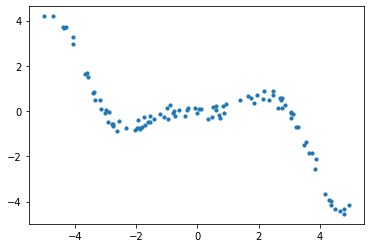

In [2]:
def regression_data(N):
  x = np.random.uniform(low=-5.0, high=5.0, size=(N, 1)).astype(np.float32)
  e = 0.2 * np.random.normal(size=(N, 1)).astype(np.float32)
  f = lambda x: 0.2 * x**2 * np.sin(2 * np.pi * x / 6)
  y = f(x) + e
  return x, y

N = 100
x, y = regression_data(N)

plt.scatter(x, y, s=10)
plt.show()

In [10]:
 model = tfk.Sequential([
    tfkl.Input((1,)),
    tfkl.Dense(100, activation=tf.nn.relu),
    #tfkl.Dense(20, activation=tf.nn.relu),
    tfkl.Dense(1, activation=None)]
)
model.summary()

#early stopping callback
cbs = [tfk.callbacks.EarlyStopping(min_delta=0,01,patience=2)]

ds_train = tf.data.Dataset.from_tensor_slices((x,y)).batch(32).repeat().prefetch(10)


loss = tfk.losses.MeanSquaredError()
opt = tfk.optimizers.Adam()
model.compile(opt,loss)

results = model.fit(x,y, steps_per_epoch=100,epochs=1000, verbose=0, callbacks=cbs, validation_split=0.2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 100)               200       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


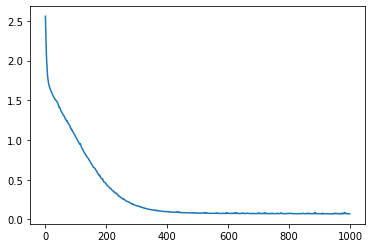

In [11]:
plt.plot(results.history['loss'])

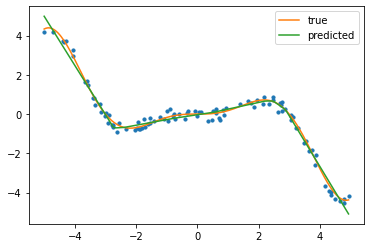

In [15]:
x_grid = np.linspace(x.min(), x.max(), 200).astype(np.float32)[:, np.newaxis]
f = lambda x: 0.2 * x**2 * np.sin(2 * np.pi * x / 6)
y_true = f(x_grid)
# your code here
y_hat = model(x_grid)


plt.scatter(x,y,s=10)
plt.plot([],[])
plt.plot(x_grid, y_true, label = 'true')
plt.plot(x_grid, y_hat, label = 'predicted')
plt.legend()
plt.show()



### binary classification

Here is another dataset that differs in two key ways from the regression example we just worked:
1. The input is now 2-dimensional
2. The targets are now binary classes

Update your model to handle both of these changes and try fitting this new data. Think about the following:
- input shape
- output function
- loss function

Since visualizing the results is a bit tricky, we have provided some code for that.

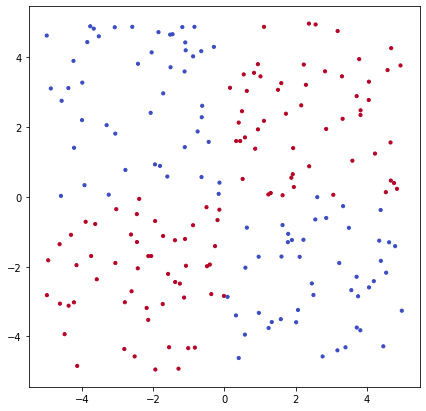

In [16]:
N = 200
def binary_classification_data(N):
  x = np.random.uniform(low=-5, high=5, size=(N, 2))
  y = (x[:, 0] * x[:, 1] > 0).astype(np.int)
  return x, y

x_train, y_train = binary_classification_data(N)
x_test, y_test = binary_classification_data(N)

plt.figure(figsize=(7, 7))
plt.scatter(x_train[:, 0], x_train[:, 1], s=10, c=y_train, cmap='coolwarm')
plt.show()

In [56]:
# your code here
a = tf.nn.softplus
model2 = tfk.Sequential([
    tfkl.Input((2,)),
    tfkl.Dense(100, activation=a),
    tfkl.Dense(20, activation=a),
    tfkl.Dense(1, activation=tf.nn.sigmoid)]
    #tfkl.Dense(10, activation=tf.nn.softmax)]
)
model2.summary()



loss = tfk.losses.BinaryCrossentropy()
opt = tfk.optimizers.Adam()
model2.compile(opt,loss)

#early stopping callback
cbs = [tfk.callbacks.EarlyStopping(min_delta=0.01,patience=0)]



ds_train = tf.data.Dataset.from_tensor_slices((x_train,y_train)).batch(N).repeat().prefetch(10)
ds_test = tf.data.Dataset.from_tensor_slices((x_test,y_test)).batch(N).repeat().prefetch(10)

results = model2.fit(ds_train, steps_per_epoch=100,epochs=100, validation_data=ds_test, callbacks=cbs, validation_steps=1)

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_77 (Dense)             (None, 100)               300       
_________________________________________________________________
dense_78 (Dense)             (None, 20)                2020      
_________________________________________________________________
dense_79 (Dense)             (None, 1)                 21        
Total params: 2,341
Trainable params: 2,341
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
100/100 [==============================] - 0s 2ms/step - loss: 0.6543 - val_loss: 0.4847
Epoch 2/100
100/100 [==============================] - 0s 2ms/step - loss: 0.3236 - val_loss: 0.1897
Epoch 3/100
100/100 [==============================] - 0s 2ms/step - loss: 0.1422 - val_loss: 0.1163
Epoch 4/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0

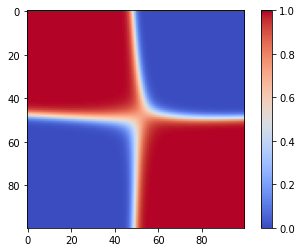

In [57]:
def binary_preds(model, x_minmax=5):
  x_grid = np.linspace(-x_minmax, x_minmax, 100)
  mesh = np.meshgrid(x_grid, x_grid)
  xs_grid = np.stack(mesh, axis=-1)
  yhat = model(xs_grid).numpy().squeeze()


  plt.imshow(yhat, cmap='coolwarm')
  plt.colorbar()

# your code here
binary_preds(model2)


### general classfication

Finally we will download and train on some real data to learn about general classification. Here is some code that will download and show some metadata about the MNIST dataset -- a collectin of handwritten digits.

Update your model to work on this data so that you model can predict the digit from its image. One new thing to keep in mind: these inputs are 2D. Later in the course we will learn about convolutional neural nets for handing such inputs more naturally, but for now, update your `tfkl.Input` layer to be 2-dimensional and then add a `tfkl.Flatten()` layer right after it to unravel the 2-d image into a 1-d vector of pixels.

Again, visualalizing the output is a bit tricky, so we have provided some code to help.

In [47]:
import tensorflow_datasets as tfds

ds, metadata = tfds.load('mnist', with_info=True)
print(metadata)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.0,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann. lecun. com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)



In [60]:
# your code here
# your code here
a = tf.nn.softplus
model3 = tfk.Sequential([
    tfkl.Input((28,28,1)),
    tfkl.Flatten(),
    tfkl.Dense(100, activation=a),
    tfkl.Dense(20, activation=a),
    #tfkl.Dense(1, activation=tf.nn.sigmoid)]
    tfkl.Dense(10, activation=tf.nn.softmax)]
)
model2.summary()



loss = tfk.losses.SparseCategoricalCrossentropy()
opt = tfk.optimizers.Adam()
model3.compile(opt,loss)

#early stopping callback
cbs = [tfk.callbacks.EarlyStopping(min_delta=0.001,patience=1)]


preprocess = lambda d: (tf.cast(d['image'], tf.float32)/255., d['label'])


ds_train = ds['train'].map(preprocess).cache().batch(32).repeat().prefetch(10)
ds_test = ds['test'].take(1000).map(preprocess).batch(1000).repeat().prefetch(10)

results = model3.fit(ds_train, steps_per_epoch=100,epochs=1000,  validation_data=ds_test, callbacks=cbs, validation_steps=1)

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_77 (Dense)             (None, 100)               300       
_________________________________________________________________
dense_78 (Dense)             (None, 20)                2020      
_________________________________________________________________
dense_79 (Dense)             (None, 1)                 21        
Total params: 2,341
Trainable params: 2,341
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
100/100 [==============================] - 1s 10ms/step - loss: 1.4463 - val_loss: 0.5926
Epoch 2/1000
100/100 [==============================] - 1s 9ms/step - loss: 0.5286 - val_loss: 0.3793
Epoch 3/1000
100/100 [==============================] - 1s 9ms/step - loss: 0.3949 - val_loss: 0.3380
Epoch 4/1000
100/100 [==============================] - 1s 10ms/step - los

In [ ]:
a=tf.nn.softplus
model=tfk.Sequential([
    tfkl.Input((28,28,1,)),
    tfkl.Flatten(),
    tfkl.Dense(100,activation=a),
    tfkl.Dense(20,activation=a),
    tfkl.Dense(10,activation=tf.nn.softmax)
])
model.summary()
cbs=[tfk.callbacks.EarlyStopping(min_delta=0.01, patience=1)]

preprocess = lambda d: (tf.cast(d['image'], tf.float32)/255., d['label'])
ds_train =ds['train'].map(preprocess).cache().batch(32).repeat().prefetch(10)
ds_test =ds['test'].take(1000).map(preprocess).batch(1000).repeat().prefetch(10)

loss=tfk.losses.SparseCategoricalCrossentropy() 
opt=tfk.optimizers.Adam()

model.compile(opt,loss)

result=model.fit(ds_train,validation_data = ds_test,
                 validation_steps = 1, steps_per_epoch=100, epochs=1000, callbacks=cbs)

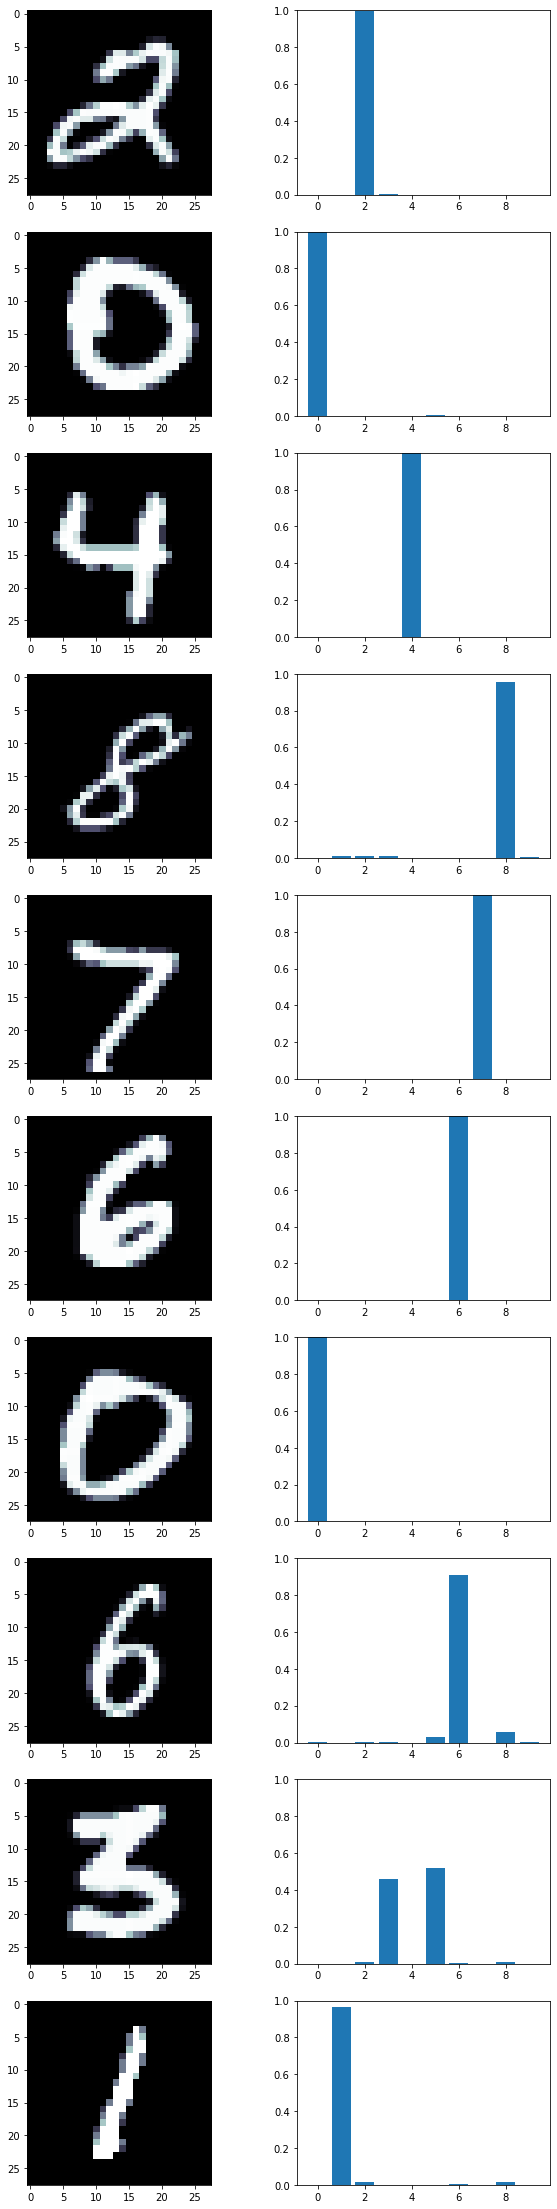

In [63]:

ims, labels = next(iter(ds['test'].map(preprocess).batch(10)))
yhat = model3(ims)
ypred = tf.argmax(yhat)

plt.figure(figsize=(10, 40))
for i in range(10):
  plt.subplot(10, 2, 2*i+1)
  plt.imshow(ims[i].numpy().squeeze(), cmap='bone')
  plt.subplot(10, 2, 2*i+2)
  plt.bar(np.arange(10), yhat[i].numpy())
  plt.ylim([0, 1])
plt.show()

# your code here